In [1]:
import keras
import tensorflow as tf
import pyfaidx
import math
import pandas as pd
import tqdm
import numpy as np
import pyBigWig
import scipy
from modisco.visualization import viz_sequence
import keras.backend as K

Using TensorFlow backend.


In [2]:
import sys
from keras.utils import CustomObjectScope
sys.path.append("/mnt/lab_data2/anusri/chrombpnet/src/training/utils/")
from losses import multinomial_nll
import matplotlib.pyplot as plt

In [3]:
# local
import one_hot


In [4]:
hg38 = pyfaidx.Fasta('/mnt/lab_data2/anusri/chrombpnet/reference/hg38.genome.fa')

In [5]:
NARROW_PEAK=["chr", "start", "end", "1", "2", "3", "4", "5", "6", "summit"]
peaks = pd.read_csv("/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/GM12878/data/peaks_no_blacklist.bed", sep="\t", names=NARROW_PEAK)


In [6]:
bw = pyBigWig.open("/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/GM12878/data/GM12878_unstranded.bw")


In [7]:

train_peaks = peaks[(peaks["chr"]!="chr1")&(peaks["chr"]!="chr2")]
val_peaks = peaks[(peaks["chr"]=="chr2")]
test_peaks = peaks[(peaks["chr"]=="chr1")]

In [8]:
def get_cts(bw, peaks_df, width=2000): 
    vals = []
    for i, r in peaks_df.iterrows(): 
        vals.append(np.nan_to_num(bw.values(r['chr'], r['start']+r['summit'] - width//2, r['start'] + r['summit'] + width//2)))
    return np.array(vals)

In [9]:
def get_seq(genome, peaks_df, width=2000): 
    vals=[]
    for i, r in peaks_df.iterrows():
        vals.append(str(genome[r['chr']][(r['start']+r['summit'] - width//2):(r['start'] + r['summit'] + width//2)]))
    return one_hot.dna_to_one_hot(vals)

In [10]:
def softmax(x, temp=1):
    norm_x = x - np.mean(x,axis=1, keepdims=True)
    return np.exp(temp*norm_x)/np.sum(np.exp(temp*norm_x), axis=1, keepdims=True)

In [11]:
train_peaks_cts = get_cts(bw, train_peaks)
val_peaks_cts = get_cts(bw, val_peaks)
test_peaks_cts = get_cts(bw, test_peaks)

In [12]:
train_peaks_seqs = get_seq(hg38, train_peaks)
val_peaks_seqs = get_seq(hg38, val_peaks)
test_peaks_seqs = get_seq(hg38, test_peaks)

In [13]:
def get_jsd(preds, cts, min_sum=10):
    return np.array([scipy.spatial.distance.jensenshannon(x,y) for x,y in zip(preds, cts) \
        if y.sum()>min_sum])

In [14]:
def model_1conv():
    inp = tf.keras.Input((2000,4))
    x = tf.keras.layers.Conv1D(1, 100, padding='same')(inp) 
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Flatten()(x)
    return tf.keras.Model(inputs=inp, outputs=x)

In [15]:
model_bias = model_1conv()

In [16]:
model_bias.compile(
    optimizer="adam",
    loss=multinomial_nll,
)

In [17]:
model_bias.fit(train_peaks_seqs,
          train_peaks_cts,
         batch_size=1024,
         epochs=50,
         validation_data=(val_peaks_seqs, val_peaks_cts),
        shuffle=True)

Epoch 1/50
224/224 [==============================] - 16s 48ms/step - loss: 5489.6863 - val_loss: 3857.7876
Epoch 2/50
224/224 [==============================] - 7s 30ms/step - loss: 3878.3019 - val_loss: 3505.8472
Epoch 3/50
224/224 [==============================] - 7s 29ms/step - loss: 3614.7012 - val_loss: 3436.2964
Epoch 4/50
224/224 [==============================] - 6s 27ms/step - loss: 3577.5933 - val_loss: 3418.1760
Epoch 5/50
224/224 [==============================] - 6s 26ms/step - loss: 3561.9679 - val_loss: 3411.8838
Epoch 6/50
224/224 [==============================] - 8s 34ms/step - loss: 3567.0673 - val_loss: 3410.5393
Epoch 7/50
224/224 [==============================] - 6s 28ms/step - loss: 3554.2932 - val_loss: 3408.7942
Epoch 8/50
224/224 [==============================] - 6s 28ms/step - loss: 3558.9444 - val_loss: 3407.9958
Epoch 9/50
224/224 [==============================] - 7s 30ms/step - loss: 3554.7734 - val_loss: 3407.5210
Epoch 10/50
224/224 [===============

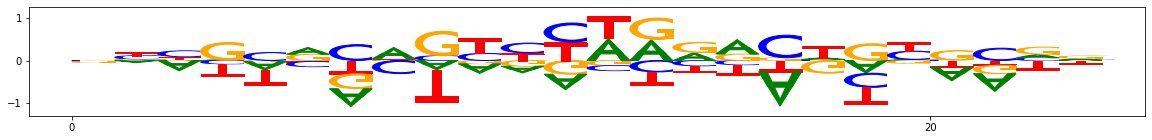

In [18]:
viz_sequence.plot_weights(model_bias.layers[1].get_weights()[0][50-13:50+11,:,0], subticks_frequency=20)
np.savetxt("44_shift_model_cnn.pwm",model_bias.layers[1].get_weights()[0][50-13:50+11,:,0])

In [19]:
bw = pyBigWig.open("/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet_incorrect_shift/ATAC_PE/GM12878/data/GM12878_unstranded.bw")


In [20]:
train_peaks_cts = get_cts(bw, train_peaks)
val_peaks_cts = get_cts(bw, val_peaks)
test_peaks_cts = get_cts(bw, test_peaks)

In [21]:
model_bias = model_1conv()
model_bias.compile(
    optimizer="adam",
    loss=multinomial_nll,
)
model_bias.fit(train_peaks_seqs,
          train_peaks_cts,
         batch_size=1024,
         epochs=50,
         validation_data=(val_peaks_seqs, val_peaks_cts),
        shuffle=True)

Epoch 1/50
224/224 [==============================] - 8s 33ms/step - loss: 5564.5603 - val_loss: 4265.7188
Epoch 2/50
224/224 [==============================] - 6s 29ms/step - loss: 4165.0937 - val_loss: 3817.9028
Epoch 3/50
224/224 [==============================] - 7s 30ms/step - loss: 3981.4909 - val_loss: 3810.4216
Epoch 4/50
224/224 [==============================] - 6s 27ms/step - loss: 3949.0700 - val_loss: 3808.9871
Epoch 5/50
224/224 [==============================] - 7s 31ms/step - loss: 3963.7219 - val_loss: 3808.6584
Epoch 6/50
224/224 [==============================] - 6s 28ms/step - loss: 3979.0774 - val_loss: 3808.0032
Epoch 7/50
224/224 [==============================] - 6s 28ms/step - loss: 3963.5502 - val_loss: 3808.4702
Epoch 8/50
224/224 [==============================] - 6s 27ms/step - loss: 3959.2563 - val_loss: 3807.5071
Epoch 9/50
224/224 [==============================] - 6s 27ms/step - loss: 3960.7753 - val_loss: 3807.6472
Epoch 10/50
224/224 [================

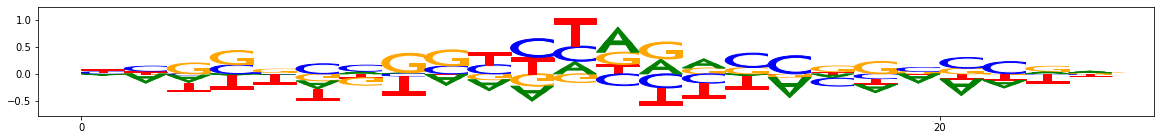

In [22]:
viz_sequence.plot_weights(model_bias.layers[1].get_weights()[0][50-12:50+12,:,0], subticks_frequency=20)
np.savetxt("45_shift_model_cnn.pwm",model_bias.layers[1].get_weights()[0][50-12:50+12,:,0])

In [33]:
def model_1conv():
    inp = tf.keras.Input((2000,4))
    x = tf.keras.layers.Conv1D(1, 20, padding='same')(inp) 
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Flatten()(x)
    return tf.keras.Model(inputs=inp, outputs=x)

bw = pyBigWig.open("/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet_incorrect_shift/DNASE_SE/GM12878/data/GM12878_unstranded.bw")


In [34]:
NARROW_PEAK=["chr", "start", "end", "1", "2", "3", "4", "5", "6", "summit"]
#peaks = pd.read_csv("/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/DNASE_PE/HEPG2/negatives_data/negatives_with_summit.bed", sep="\t", names=NARROW_PEAK)
#peaks = pd.read_csv("/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/DNASE_PE/HEPG2/data/peaks_no_blacklist.bed", sep="\t", names=NARROW_PEAK)
peaks = pd.read_csv("/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/DNASE_SE/GM12878/data/peaks_no_blacklist.bed", sep="\t", names=NARROW_PEAK)


train_peaks = peaks[(peaks["chr"]!="chr1")&(peaks["chr"]!="chr2")]
val_peaks = peaks[(peaks["chr"]=="chr2")]
test_peaks = peaks[(peaks["chr"]=="chr1")]

train_peaks_cts = get_cts(bw, train_peaks)
val_peaks_cts = get_cts(bw, val_peaks)
test_peaks_cts = get_cts(bw, test_peaks)

train_peaks_seqs = get_seq(hg38, train_peaks)
val_peaks_seqs = get_seq(hg38, val_peaks)
test_peaks_seqs = get_seq(hg38, test_peaks)

In [35]:
model_bias = model_1conv()
model_bias.compile(
    optimizer="adam",
    loss=multinomial_nll,
)
model_bias.fit(train_peaks_seqs,
          train_peaks_cts,
         batch_size=1024,
         epochs=50,
         validation_data=(val_peaks_seqs, val_peaks_cts),
        shuffle=True)

Epoch 1/50
104/104 [==============================] - 3s 25ms/step - loss: 755.5942 - val_loss: 689.8837
Epoch 2/50
104/104 [==============================] - 3s 26ms/step - loss: 727.3418 - val_loss: 675.3561
Epoch 3/50
104/104 [==============================] - 2s 22ms/step - loss: 714.4373 - val_loss: 671.9149
Epoch 4/50
104/104 [==============================] - 2s 23ms/step - loss: 709.9803 - val_loss: 670.8571
Epoch 5/50
104/104 [==============================] - 2s 22ms/step - loss: 712.8067 - val_loss: 670.5778
Epoch 6/50
104/104 [==============================] - 2s 22ms/step - loss: 708.9622 - val_loss: 670.4891
Epoch 7/50
104/104 [==============================] - 2s 23ms/step - loss: 711.0799 - val_loss: 670.4355
Epoch 8/50
104/104 [==============================] - 2s 22ms/step - loss: 708.5226 - val_loss: 670.4481
Epoch 9/50
104/104 [==============================] - 2s 22ms/step - loss: 710.8598 - val_loss: 670.4379
Epoch 10/50
104/104 [==============================] - 

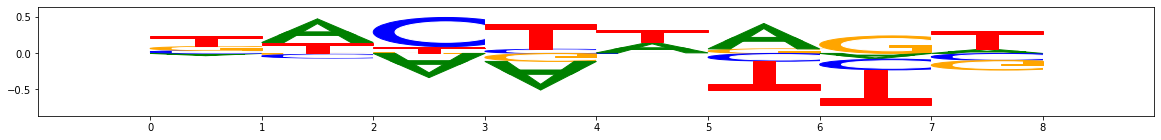

In [36]:
viz_sequence.plot_weights(model_bias.layers[1].get_weights()[0][10-5:10+3,:,0], subticks_frequency=1)
np.savetxt("no_shift_model_cnn.pwm",model_bias.layers[1].get_weights()[0][10-5:10+3,:,0])

In [42]:
bw = pyBigWig.open("/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/DNASE_SE/GM12878/data/GM12878_unstranded.bw")
#bw = pyBigWig.open("/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/DNASE_PE/HEPG2/data/HEPG2_unstranded.bw")


In [43]:
train_peaks_cts = get_cts(bw, train_peaks)
val_peaks_cts = get_cts(bw, val_peaks)
test_peaks_cts = get_cts(bw, test_peaks)

In [44]:
model_bias = model_1conv()
model_bias.compile(
    optimizer="adam",
    loss=multinomial_nll,
)
model_bias.fit(train_peaks_seqs,
          train_peaks_cts,
         batch_size=1024,
         epochs=50,
         validation_data=(val_peaks_seqs, val_peaks_cts),
        shuffle=True)

Epoch 1/50
104/104 [==============================] - 3s 27ms/step - loss: 773.7426 - val_loss: 724.3636
Epoch 2/50
104/104 [==============================] - 2s 22ms/step - loss: 769.4311 - val_loss: 698.0092
Epoch 3/50
104/104 [==============================] - 2s 23ms/step - loss: 720.9023 - val_loss: 657.5361
Epoch 4/50
104/104 [==============================] - 2s 23ms/step - loss: 689.3102 - val_loss: 648.3847
Epoch 5/50
104/104 [==============================] - 2s 23ms/step - loss: 688.2121 - val_loss: 643.9907
Epoch 6/50
104/104 [==============================] - 3s 25ms/step - loss: 679.2013 - val_loss: 641.5265
Epoch 7/50
104/104 [==============================] - 2s 22ms/step - loss: 681.4343 - val_loss: 640.0801
Epoch 8/50
104/104 [==============================] - 2s 23ms/step - loss: 677.2069 - val_loss: 639.2126
Epoch 9/50
104/104 [==============================] - 2s 23ms/step - loss: 679.8759 - val_loss: 638.7197
Epoch 10/50
104/104 [==============================] - 

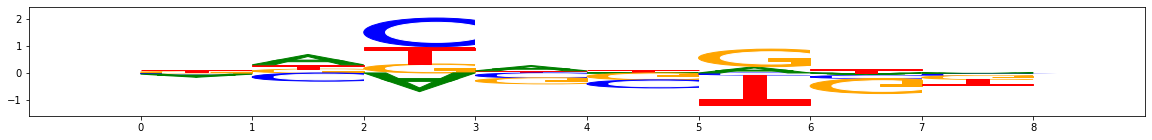

In [45]:
viz_sequence.plot_weights(model_bias.layers[1].get_weights()[0][10-5:10+3,:,0], subticks_frequency=1)
np.savetxt("01_shift_model_cnn.pwm",model_bias.layers[1].get_weights()[0][10-5:10+3,:,0])

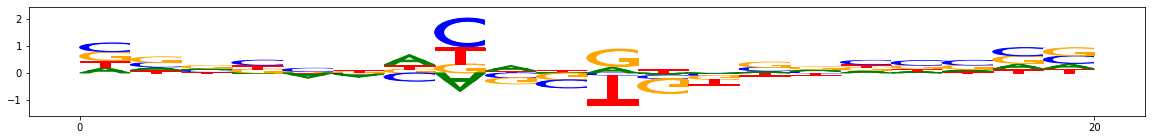

In [46]:
viz_sequence.plot_weights(model_bias.layers[1].get_weights()[0], subticks_frequency=20)
